# Ensemble - Voting 방식
- 서로 다른 종류의 알고리즘들을 결합하여 다수결 방식으로 최종 결과를 출력한다.

## Voting의 유형 (분류)
- 비슷한 성능을 내면서 서로 다른 예측하는 것이 많은 모델들을 묶어줄 때 성능이 올라간다.
1. **hard voting**
    - 다수의 추정기가 결정한 예측값들 중 많은 것을 선택하는 방식
    
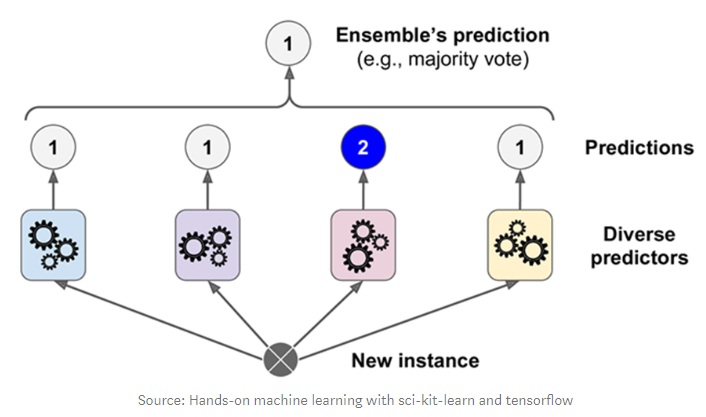  

2. **soft voting**
    - 다수의 추정기에서 각 레이블별 예측한 확률들의 평균을 내서 높은 레이블값을 결과값으로 선택하는 방식

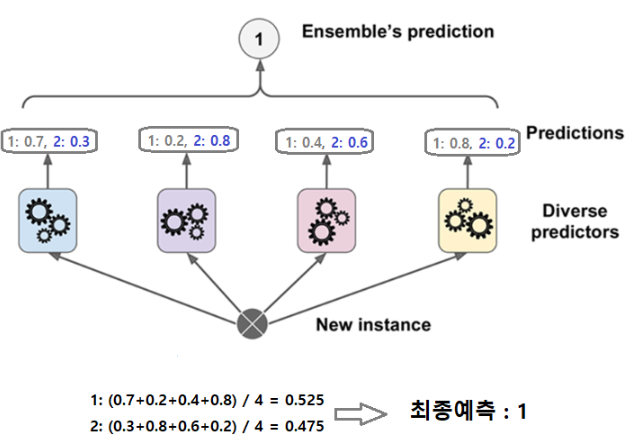

- 일반적으로 soft voting이 성능이 더 좋다.    
- 비슷한 성능을 내면서 서로 다른 예측하는 것이 많은 모델들을 묶어줄 때 성능이 올라간다.

## VotingClassifier 클래스 이용
- 매개변수
    - estimators : 앙상블할 모델들 설정.  ("추정기이름", 추정기) 의 튜플을 리스트로 묶어서 전달
        - \[("모델이름", 모델객체), ...\]
    - voting: voting 방식.
        - "hard"(기본값), "soft"  지정

### 분류문제를 위한  Voting Ensemble에서  모델들간의 상관관계
- 상관관계가 높은 모델을 Voting 방식 앙상블에 포함시키는 것은 바람직 하지 않다.
- 모델간의 상관관계가 높다는 것은 두 모델이 동일한 예측을 한다는 것이다. 같은 예측을 하는 모델들을 모아서 추론하는 것은 의미가 없다. 
- Voting방식(다수결 투표방식)의 앙상블은 각각 좋은 성능을 내지만 다른 예측을 하는 다양한 모델을 모아서 하는 것이 좋다. 대부분의 모델들이 동일한 예측을 만든다면 새로운 모델을 추가해 얻는 이득이 적다.

#### 모델간의 상관관계 확인
- 각 모델의 예측 결과를 이용해 상관계수를 구한다.

##### import

In [1]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
X, y = cancer_data.data, cancer_data.target
X.shape, y.shape

((569, 30), (569,))

##### 데이터셋 로딩 및 train/test set 나누기

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    random_state=1,
                                                    test_size=0.2,
                                                    )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

##### Data전처리
- SVM, KNN, LogisticRegression은 Feature Scaling 전처리 데이터를 사용
- Random Forest, XGBoost는 Decision Tree기반이므로 Feature Scaling이 필요없다.

In [3]:
# feature scaling
from sklearn.preprocessing import StandardScaler
cancer_scaler = StandardScaler()
X_train_scaled = cancer_scaler.fit_transform(X_train)
X_test_scaled = cancer_scaler.transform(X_test)

##### 모델들 생성, 학습, 평가

In [4]:
# voting classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from metrics import print_metrics_classification as pmc, cm_viz

In [12]:
# 모델 생성
## SVM, KNN -> pipeline
## 각 모델은 튜닝까지 완료된 상태로 가정

knn_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

svc_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC(C=1.0, gamma=0.1, probability=True)) # svc는 확률값을 제공하지 않음. probability=True로 설정해야 함
])

lr_clf = LogisticRegression(C=1.0, random_state=0)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, random_state=0)

In [39]:
clfs = [('knn', knn_clf), ('svc', svc_clf), ('lr', lr_clf), ('rf', rf_clf), ('xgb', xgb_clf)]

scores={}
test_pred_dict = {}

for k, clf in clfs:
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    proba_train = clf.predict_proba(X_train)[:, 1]
    proba_test = clf.predict_proba(X_test)[:, 1]
    
    scores[(k , 'train')] = accuracy_score(y_train, pred_train)
    scores[(k , 'test')] = accuracy_score(y_test, pred_test)
    pmc(y_train, pred_train, title=f'{k} train')
    pmc(y_test, pred_test, title=f'{k} test')
    print('++++++++++++++++++++++++++++++++++++++++')
    
    test_pred_dict[k] = pred_test
# import pandas as pd
# scores_df = pd.DataFrame(scores)
# scores_df

==========knn train==========
정확도(Accuracy): 0.9802197802197802
재현율(Recall) : 0.9929824561403509
정밀도(Precision): 0.9758620689655172
F1 Score: 0.9843478260869565
==========knn test==========
정확도(Accuracy): 0.9736842105263158
재현율(Recall) : 1.0
정밀도(Precision): 0.96
F1 Score: 0.9795918367346939
++++++++++++++++++++++++++++++++++++++++
==========svc train==========
정확도(Accuracy): 0.9934065934065934
재현율(Recall) : 1.0
정밀도(Precision): 0.9895833333333334
F1 Score: 0.9947643979057591
==========svc test==========
정확도(Accuracy): 0.9385964912280702
재현율(Recall) : 0.9305555555555556
정밀도(Precision): 0.9710144927536232
F1 Score: 0.9503546099290779
++++++++++++++++++++++++++++++++++++++++
==========lr train==========
정확도(Accuracy): 0.9384615384615385
재현율(Recall) : 0.9649122807017544
정밀도(Precision): 0.9385665529010239
F1 Score: 0.9515570934256056
==========lr test==========
정확도(Accuracy): 0.956140350877193
재현율(Recall) : 0.9722222222222222
정밀도(Precision): 0.958904109589041
F1 Score: 0.9655172413793104
+++

c:\Users\hyenz\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


==========rf train==========
정확도(Accuracy): 0.9824175824175824
재현율(Recall) : 1.0
정밀도(Precision): 0.9726962457337884
F1 Score: 0.986159169550173
==========rf test==========
정확도(Accuracy): 0.9473684210526315
재현율(Recall) : 0.9583333333333334
정밀도(Precision): 0.9583333333333334
F1 Score: 0.9583333333333334
++++++++++++++++++++++++++++++++++++++++
==========xgb train==========
정확도(Accuracy): 1.0
재현율(Recall) : 1.0
정밀도(Precision): 1.0
F1 Score: 1.0
==========xgb test==========
정확도(Accuracy): 0.9736842105263158
재현율(Recall) : 0.9861111111111112
정밀도(Precision): 0.9726027397260274
F1 Score: 0.9793103448275863
++++++++++++++++++++++++++++++++++++++++


In [32]:
import pandas as pd
trains = {}
tests = {}
for (k0, k1), v in scores.items():
    if k1 == 'train':
        trains[k0] = v
    else:
        tests[k0] = v
scores_ = {
    'train': trains,
    'test': tests
}
scores_df = pd.DataFrame(scores_)
scores_df

,train,test
knn,0.980220,0.973684
svc,0.993407,0.938596
lr,0.938462,0.956140
rf,0.982418,0.947368
xgb,1.000000,0.973684


In [46]:
test_pred_df = pd.DataFrame(test_pred_dict)
test_pred_df.corr()

,knn,svc,lr,rf,xgb
knn,1.000000,0.892935,0.962213,0.905824,0.923684
svc,0.892935,1.000000,0.853211,0.834140,0.853211
lr,0.962213,0.853211,1.000000,0.905447,0.885733
rf,0.905824,0.834140,0.905447,1.000000,0.943340
xgb,0.923684,0.853211,0.885733,0.943340,1.000000


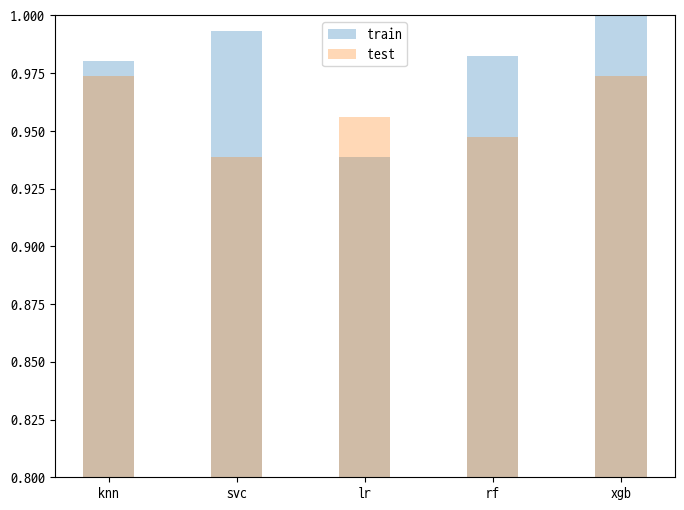

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(scores_df.index, scores_df['train'], label='train', width=0.4, alpha=0.3)
plt.bar(scores_df.index, scores_df['test'], label='test', width=0.4, alpha=0.3)
# train은 왼쪽, test는 오른쪽으로 이동
# scores_df.index은 string이므로 숫자로 변환
plt.ylim(0.8, 1.0)
plt.legend()
plt.show()

In [15]:
import numpy as np
train_mean = np.mean([v for k, v in scores.items() if 'train' in k])
test_mean = np.mean([v for k, v in scores.items() if 'test' in k])
print(f'train mean: {train_mean:.4f}, test mean: {test_mean:.4f}')

train mean: 0.9789, test mean: 0.9579


In [52]:
clfs = [('knn', knn_clf), ('svc', svc_clf), ('xgb', xgb_clf)] # , ('rf', rf_clf), ('lr', lr_clf)]

voting_clf = VotingClassifier(estimators=clfs,
                                voting='soft',
                                n_jobs=-1,
                                verbose=1,
                                )

In [53]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(gamma=0.1,
                                                   probability=True))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stop...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0, ...))],
                 n_jobs=-1, verbose=1, voting='soft')

==========Train==========
정확도(Accuracy): 0.9934065934065934
재현율(Recall) : 1.0
정밀도(Precision): 0.9895833333333334
F1 Score: 0.9947643979057591
Averaged Precision: 1.0
ROC-AUC Score: 1.0
==========Test==========
정확도(Accuracy): 0.9736842105263158
재현율(Recall) : 1.0
정밀도(Precision): 0.96
F1 Score: 0.9795918367346939
Averaged Precision: 0.9946023355240718
ROC-AUC Score: 0.992063492063492


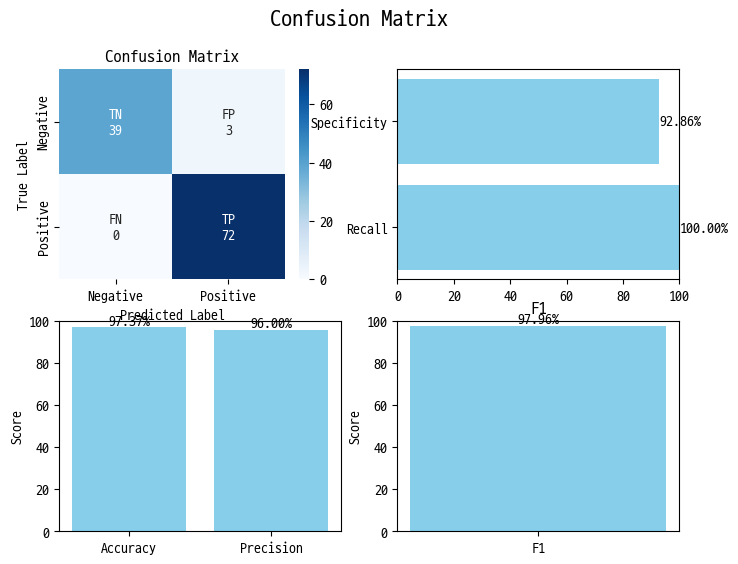

In [54]:
pred_train = voting_clf.predict(X_train)
pred_test = voting_clf.predict(X_test)
proba_train = voting_clf.predict_proba(X_train)
proba_test = voting_clf.predict_proba(X_test)

from metrics import print_metrics_classification, cm_viz
print_metrics_classification(y_train, pred_train, title='Train', pos_proba=proba_train[:,1])
print_metrics_classification(y_test, pred_test, title='Test', pos_proba=proba_test[:,1])

cm_viz(y_test,
        pred_test,
        cmap='Blues',
        color='skyblue',
        figsize=(8,6),
        title='Confusion Matrix',
        )

In [57]:
voting_clf_hard = VotingClassifier(estimators=clfs,
                                # voting='soft', # default : hard
                                n_jobs=-1,
                                verbose=1,
                                )

voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier())])),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('svc',
                                               SVC(gamma=0.1,
                                                   probability=True))])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stop...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0, ...))],
                 n_jobs=-1, verbose=1)

==========Train==========
정확도(Accuracy): 0.9934065934065934
재현율(Recall) : 1.0
정밀도(Precision): 0.9895833333333334
F1 Score: 0.9947643979057591
==========Test==========
정확도(Accuracy): 0.9824561403508771
재현율(Recall) : 1.0
정밀도(Precision): 0.972972972972973
F1 Score: 0.9863013698630138


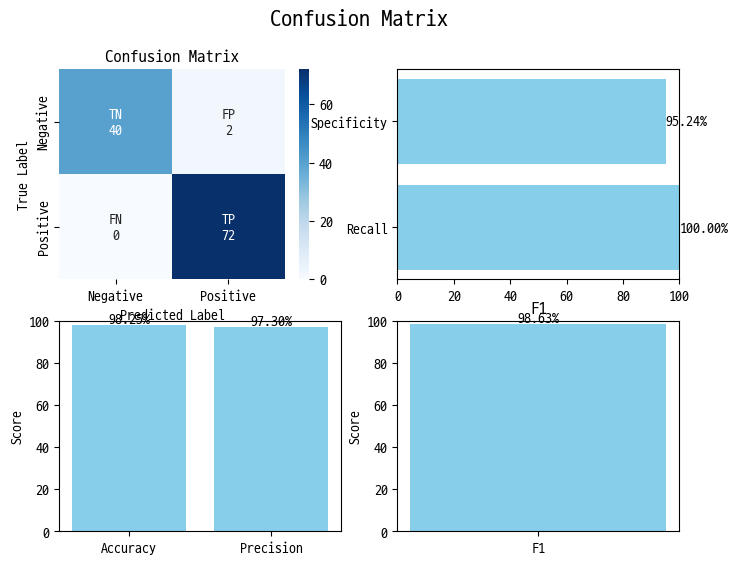

In [59]:
pred_train = voting_clf_hard.predict(X_train)
pred_test = voting_clf_hard.predict(X_test)
# proba_train = voting_clf_hard.predict_proba(X_train)
# proba_test = voting_clf_hard.predict_proba(X_test)

from metrics import print_metrics_classification, cm_viz
print_metrics_classification(y_train, pred_train, title='Train')
print_metrics_classification(y_test, pred_test, title='Test')

cm_viz(y_test,
        pred_test,
        cmap='Blues',
        color='skyblue',
        figsize=(8,6),
        title='Confusion Matrix',
        )

# Voting - 회귀

- 각모델이 값을 추론하면 그 값들의 평균으로 최종 결과를 사용한다.

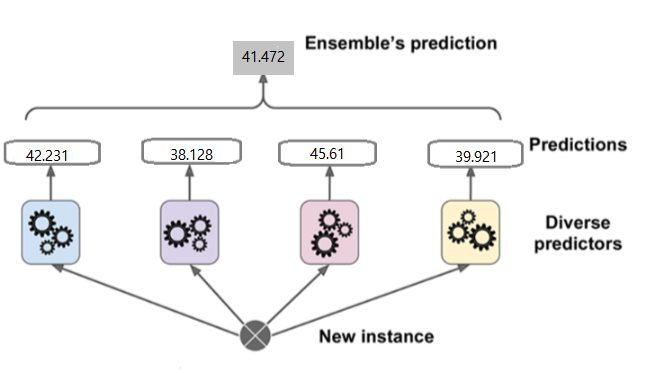



## VotingRegressor 클래스 이용

- 매개변수
    - estimators : 앙상블할 모델들 설정.  ("추정기이름", 추정기) 의 튜플을 리스트로 묶어서 전달

In [62]:
# Voting Regressor
from dataset import get_boston_dataset
X_train, X_test, y_train, y_test = get_boston_dataset()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((379, 13), (127, 13), (379,), (127,))

In [68]:
# 모델 생성
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from metrics import print_metrics_regression as pmr

line_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
knn_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])
svr_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svr', SVR(C=1.0, gamma=0.1))
])
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=3, random_state=0)
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, random_state=0)

regs = [
    ('line', line_reg),
    ('knn', knn_reg),
    ('svr', svr_reg),
    ('rf', rf_reg),
    ('xgb', xgb_reg)
]

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_scores = {
    'MAE': {},
    'MSE': {},
    'RMSE': {},
    'R2': {}
}
test_scores = {
    'MAE': {},
    'MSE': {},
    'RMSE': {},
    'R2': {}
}

score_name = ['MAE', 'MSE', 'RMSE', 'R2']
score_func = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': lambda y, pred: mean_squared_error(y, pred, squared=False),
    'R2': r2_score
}

for k, reg in regs:
    reg.fit(X_train, y_train)
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    
    pmr(y_train, pred_train, title=f'{k} train')
    pmr(y_test, pred_test, title=f'{k} test')
    print('++++++++++++++++++++++++++++++++++++++++')
    
    for name in score_name:
        train_scores[name][k] = score_func[name](y_train, pred_train)
        test_scores[name][k] = score_func[name](y_test, pred_test)

==========line train==========
MAE: 3.3851968027571853
MSE: 23.327378902305774
RMSE: 4.829842533903748
R2 Score: 0.717672243569379
==========line test==========
MAE: 3.1635051115298656
MSE: 18.96659799622575
RMSE: 4.35506578552216
R2 Score: 0.788669757494949
++++++++++++++++++++++++++++++++++++++++
==========knn train==========
MAE: 2.3506068601583117
MSE: 13.918963588390502
RMSE: 3.7308127249153773
R2 Score: 0.8315408782869571
==========knn test==========
MAE: 2.6692913385826778
MSE: 17.22572598425197
RMSE: 4.150388654602358
R2 Score: 0.8080669580120837
++++++++++++++++++++++++++++++++++++++++
==========svr train==========
MAE: 2.9758301148977977
MSE: 29.099482179876123
RMSE: 5.394393587779457
R2 Score: 0.647813346216741
==========svr test==========
MAE: 3.306848961133546
MSE: 30.45554003524153
RMSE: 5.51865382455192
R2 Score: 0.660657295391053
++++++++++++++++++++++++++++++++++++++++
==========rf train==========
MAE: 2.5033953923801735
MSE: 10.756133570897822
RMSE: 3.2796544895610302

In [87]:
train_scores_df = pd.DataFrame(train_scores)
test_scores_df = pd.DataFrame(test_scores)
train_scores_df, test_scores_df

(           MAE        MSE      RMSE        R2
 line  3.385197  23.327379  4.829843  0.717672
 knn   2.350607  13.918964  3.730813  0.831541
 svr   2.975830  29.099482  5.394394  0.647813
 rf    2.503395  10.756134  3.279654  0.869820
 xgb   0.482839   0.408942  0.639485  0.995051,
            MAE        MSE      RMSE        R2
 line  3.163505  18.966598  4.355066  0.788670
 knn   2.669291  17.225726  4.150389  0.808067
 svr   3.306849  30.455540  5.518654  0.660657
 rf    2.793100  15.941581  3.992691  0.822375
 xgb   2.139053   9.808385  3.131834  0.890713)

Text(0.5, 1.0, 'Test Scores')

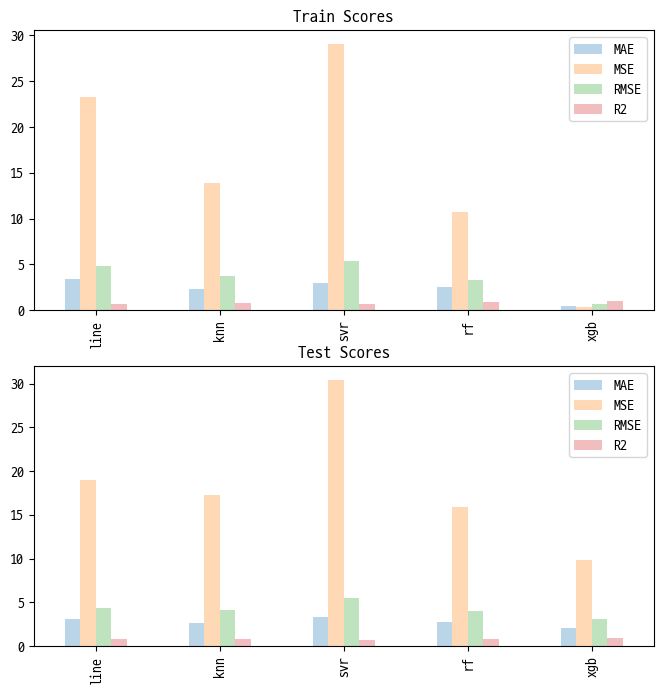

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
train_scores_df.plot(kind='bar', alpha=0.3, ax=axs[0])
axs[0].set_title('Train Scores')
test_scores_df.plot(kind='bar', alpha=0.3, ax=axs[1])
axs[1].set_title('Test Scores')

In [146]:
regs = [
    ('line', line_reg),
    ('knn', knn_reg),
    ('svr', svr_reg),
    ('rf', rf_reg),
    ('xgb', xgb_reg)
]

vote_reg = VotingRegressor(estimators=regs,
                        n_jobs=-1,
                        verbose=1,
                        weights=[1, 1, 0.5, 1, 1.5],
                        )

vote_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('line',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lr', LinearRegression())])),
                            ('knn',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsRegressor())])),
                            ('svr',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svr', SVR(gamma=0.1))])),
                            ('rf',
                             RandomForestRegressor(max_depth=3,
                                                   n_estimators=200,
                                                   random_state=0)),
                            ('xgb'...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=0, ...))],
                n_jobs=-1, verbose=1, weights=[1, 1, 0.5, 1, 1.5])

In [147]:
pred_train = vote_reg.predict(X_train)
pred_test = vote_reg.predict(X_test)

pmr(y_train, pred_train, title='Train')
pmr(y_test, pred_test, title='Test')

==========Train==========
MAE: 1.7581938758068218
MSE: 6.691023136557253
RMSE: 2.5867012074372355
R2 Score: 0.9190195538778314
==========Test==========
MAE: 2.2666511005932004
MSE: 11.188200464138701
RMSE: 3.3448767487216475
R2 Score: 0.8753384704124557


In [148]:
score_name = ['MAE', 'MSE', 'RMSE', 'R2']
score_func = {
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    'RMSE': lambda y, pred: mean_squared_error(y, pred, squared=False),
    'R2': r2_score
}

test_scores_voting = {}
train_scores_voting = {}

for name in score_name:
    test_scores_voting[name] = score_func[name](y_test, pred_test)
    train_scores_voting[name] = score_func[name](y_train, pred_train)

In [155]:
train_scores_df.loc['vote'] = pd.Series(train_scores_voting)
test_scores_df.loc['vote'] = pd.Series(test_scores_voting)

In [156]:
train_scores_df, test_scores_df

(           MAE        MSE      RMSE        R2
 line  3.385197  23.327379  4.829843  0.717672
 knn   2.350607  13.918964  3.730813  0.831541
 svr    2.97583  29.099482  5.394394  0.647813
 rf    2.503395  10.756134  3.279654   0.86982
 xgb   0.482839   0.408942  0.639485  0.995051
 vote  1.758194   6.691023  2.586701   0.91902,
            MAE        MSE      RMSE        R2
 line  3.163505  18.966598  4.355066   0.78867
 knn   2.669291  17.225726  4.150389  0.808067
 svr   3.306849   30.45554  5.518654  0.660657
 rf      2.7931  15.941581  3.992691  0.822375
 xgb   2.139053   9.808385  3.131834  0.890713
 vote  2.266651    11.1882  3.344877  0.875338)

Text(0.5, 1.0, 'Test Scores')

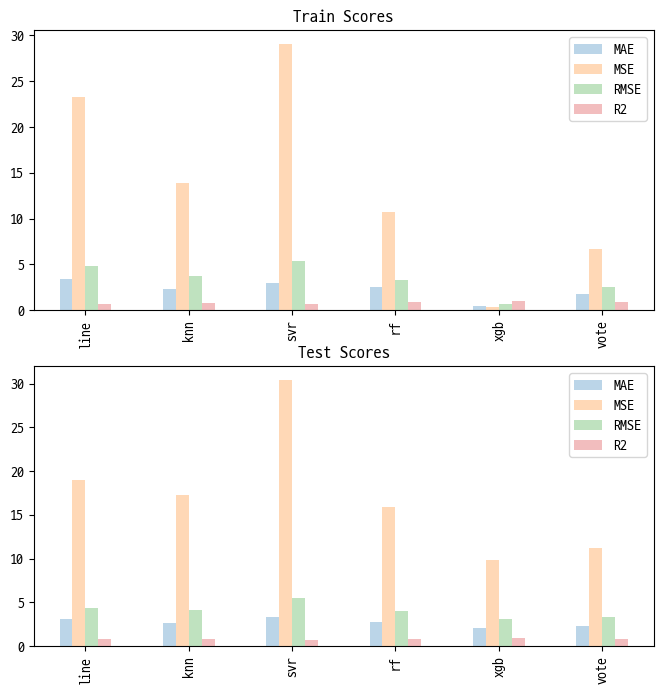

In [153]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
train_scores_df.plot(kind='bar', alpha=0.3, ax=axs[0])
axs[0].set_title('Train Scores')
test_scores_df.plot(kind='bar', alpha=0.3, ax=axs[1])
axs[1].set_title('Test Scores')

(0.0, 15.0)

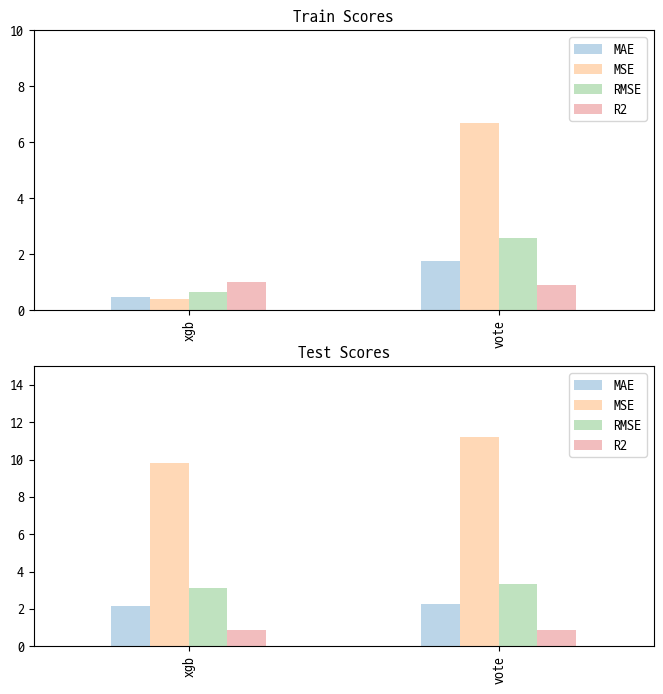

In [154]:
idx_sel = ['xgb', 'vote']
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
train_scores_df.loc[idx_sel].plot(kind='bar', alpha=0.3, ax=axs[0])
axs[0].set_title('Train Scores')
test_scores_df.loc[idx_sel].plot(kind='bar', alpha=0.3, ax=axs[1])
axs[1].set_title('Test Scores')
axs[0].set_ylim(.0, 10)
axs[1].set_ylim(.0, 15)

<Axes: >

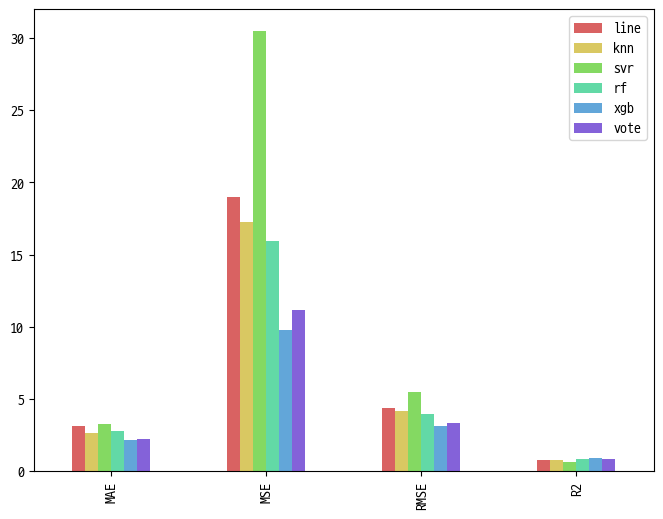

In [196]:
from test_color.color_list import rand_hex_list_hsv
colors = rand_hex_list_hsv(7, s=0.55, v=0.85)
test_scores_df.T.plot(kind='bar', figsize=(8, 6), alpha=1, color=colors)